# Dependencies

more usefull information about the fields can be found at the data [source](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236).

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import datetime

## Some preprocessing

In [2]:
# Load flight data
df_fl = pd.read_csv("flights.csv",dtype={"ORIGIN_AIRPORT":str,"DESTINATION_AIRPORT":str,"ARRIVAL_TIME":str,"DEPARTURE_TIME":str})

In [3]:
df_fl.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')

In [9]:
#df_fl[["ORIGIN_AIRPORT","DESTINATION_AIRPORT","YEAR","MONTH","DAY","ARRIVAL_TIME","DEPARTURE_TIME"]]
#df_fl.YEAR + "-" + df_fl.MONTH + "-" + df_fl.DAY + "-" + df_fl.DEPARTURE_TIME

In [10]:
# Problem: airline codes not coherent:
print(len(df_fl["ORIGIN_AIRPORT"].unique()))

628


In [11]:
# Solution: map it
# load airport codes
df_aircode1 = pd.read_csv('L_AIRPORT.csv')
df_aircode2 = pd.read_csv('L_AIRPORT_ID.csv')

# Format the airport codes
df_aircode1 = df_aircode1.reset_index()
df_aircode2 = df_aircode2.reset_index()
df_aircodes = pd.merge(df_aircode1,df_aircode2,on='Description')
aircode_dict = dict(zip(df_aircodes['Code_y'].astype(str),df_aircodes['Code_x']))
aircode_dict["10423"]  = "AUS" # 10423 was encoded to BSM which is in IRAN istead of Austin-Bergstrom

# support function
def mymapper(label):
    """function to map 5-digit to 3-letter code"""
    if len(label) == 3:
        return label
    elif len(label) == 5:
        return aircode_dict[label]
    
# Fix the airport 5-digit > 3-letter code
df_fl['O_A'] = df_fl["ORIGIN_AIRPORT"].apply(mymapper)
df_fl["D_A"] = df_fl["DESTINATION_AIRPORT"].apply(mymapper)

In [12]:
# we finally find the 322 unique domestic airports
print((len(df_fl["D_A"].unique()),len(df_fl["O_A"].unique())))

(322, 322)


In [13]:
# Load up airports
airports = pd.read_csv('airports.csv')
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [14]:
airports.shape

(322, 7)

In [24]:
# Get all the planes from the dataframe
planes = df_fl.TAIL_NUMBER.unique()


#### Fix the times from local to UTC

# Data exploration

In [80]:
df_fl.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'O_A', 'D_A', 'late_departure',
       'late_arrival'],
      dtype='object')

In [77]:
# Sneak peak
df_fl.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,O_A,D_A,late_departure,late_arrival
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,NaN,NaN,NaN,NaN,NaN,NaN,ANC,SEA,False,False
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,NaN,NaN,NaN,NaN,NaN,NaN,LAX,PBI,False,False
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,NaN,NaN,NaN,NaN,NaN,NaN,SFO,CLT,False,True
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,NaN,NaN,NaN,NaN,NaN,NaN,LAX,MIA,False,False
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,NaN,NaN,NaN,NaN,NaN,NaN,SEA,ANC,False,False


In [81]:
# Amount of flights/airport
destsize = df_fl["D_A"].value_counts().sort_index()
orsize = df_fl["O_A"].value_counts().sort_index()

# Generate boolean variable to indicate delay
# x <= 0: False (i.e. no delay)
# x  > 0: True (i.e. delay)
df_fl["late_departure"] = [True if x > 0 else False for x in df_fl["DEPARTURE_DELAY"]]
df_fl["late_arrival"] = [True if x > 0 else False for x in df_fl["ARRIVAL_DELAY"]]

# Generate ratios of delayed flights for each airport
dept_delay_df = df_fl.pivot_table("late_departure",index="O_A")
arr_delay_df  = df_fl.pivot_table("late_arrival",index="D_A")
# put them together and sort on index (for plotting later on)
delaydf = pd.concat([dept_delay_df, arr_delay_df], axis=1).sort_index()

### Question: identify hubs (flight count & delays)

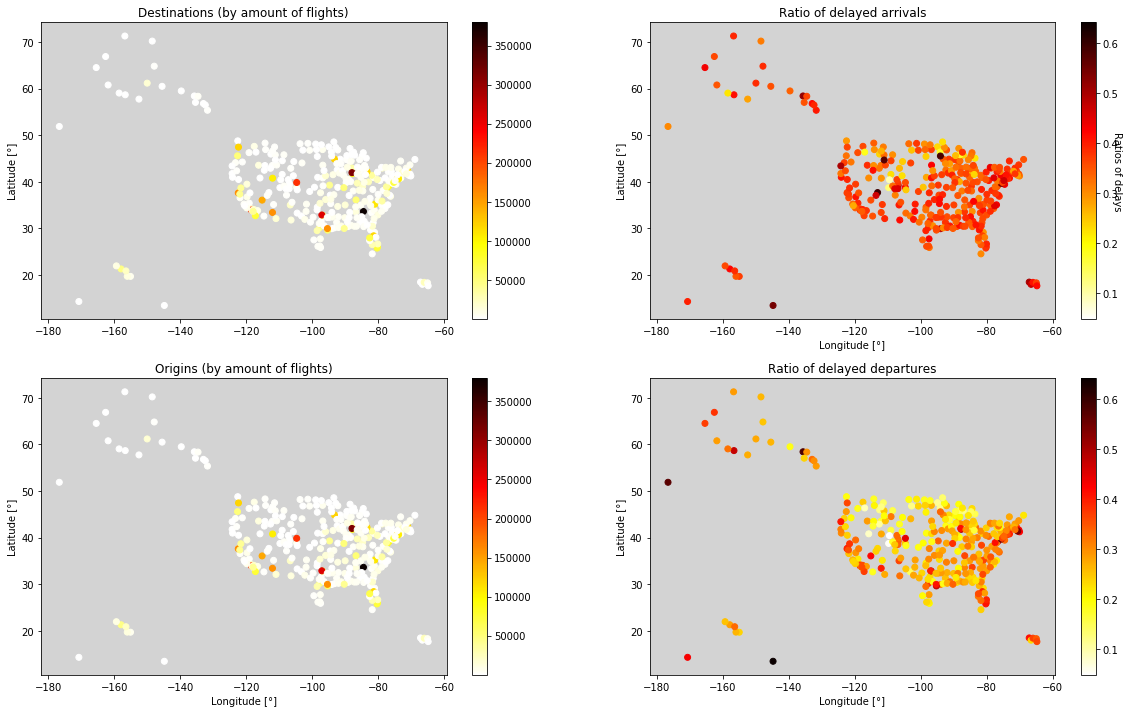

In [84]:
# Extract lat/long coordinates, sorted by IATA code
x = airports.sort_values(by="IATA_CODE")["LONGITUDE"].to_numpy()
y = airports.sort_values(by="IATA_CODE")["LATITUDE"].to_numpy()

# Make figure
plt.figure(figsize=(20,12))

# Showing airport importance based on number of flights
plt.subplot(2,2,1)
ax = plt.gca()
ax.set_facecolor('lightgrey')
plt.scatter(x,y,c=destsize,cmap="hot_r")
plt.ylabel("Latitude [°]")
plt.title("Destinations (by amount of flights)");
plt.colorbar();
#plt.clim(0,max(np.max(destsize),np.max(orsize)))

plt.subplot(2,2,3)
ax = plt.gca()
ax.set_facecolor('lightgrey')
plt.scatter(x,y,c=orsize,cmap="hot_r")
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
plt.title("Origins (by amount of flights)");
plt.colorbar();
#plt.clim(0,max(np.max(deptsize),np.max(orsize)))

# Showing ratio of delays for airports
plt.subplot(2,2,4)
ax = plt.gca()
ax.set_facecolor('lightgrey')
plt.scatter(x,y,c=delaydf["late_departure"].to_numpy(),cmap="hot_r")
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
plt.title("Ratio of delayed departures");
cbar = plt.colorbar();
#cbar.set_label('Ratios of delayed departures', rotation=270)
plt.clim(np.minimum(dept_delay_df.min(),arr_delay_df.min()),
         np.maximum(dept_delay_df.max(),arr_delay_df.max()))

plt.subplot(2,2,2)
ax = plt.gca()
ax.set_facecolor('lightgrey')
plt.scatter(x,y,c=delaydf["late_arrival"].to_numpy(),cmap="hot_r")
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
plt.title("Ratio of delayed arrivals");
cbar = plt.colorbar();
cbar.set_label('Ratios of delays', rotation=270)
plt.clim(np.minimum(dept_delay_df.min(),arr_delay_df.min()),
         np.maximum(dept_delay_df.max(),arr_delay_df.max()))

### Question: is there a correlation between late departure and late arrival?

In [85]:
from scipy.stats.stats import pearsonr
pearsonr(dept_delay_df,arr_delay_df)
# => positive corelation ratio, but not purely linear

(array([0.50558084]), array([2.68714463e-22]))

### Question: what does the delay distribution look like?

In [65]:
# get delay times
a = df_fl["ARRIVAL_DELAY"].dropna().to_numpy()
d = df_fl["DEPARTURE_DELAY"].dropna().to_numpy()
# calculate kernel
kernel_a = stats.gaussian_kde(a)
kernel_d = stats.gaussian_kde(d)
# generate variables
dtime = np.arange(-50,100)
y_a = kernel_a(dtime)
y_d = kernel_d(dtime);

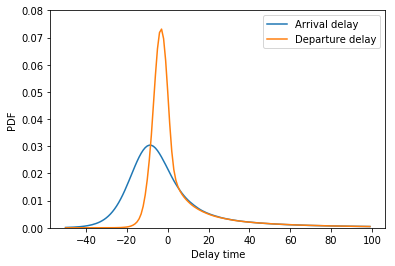

In [68]:
plt.plot(dtime,y_a,label="Arrival delay")
plt.plot(dtime,y_d,label="Departure delay")
plt.xlabel("Delay time")
plt.ylabel("PDF")
plt.legend();
plt.ylim(0,0.08);

### Q: what does the network look like?

In [86]:
# Get an idea of the flight combinations
flight_counts = df_fl.groupby(['O_A', 'D_A']).size()
# Get the edges and write the to a list:
edges = [(x[0], x[1], {'weight': flight_counts[x]}) for x in flight_counts.index.tolist()]
# generate network from edges
G = nx.DiGraph()
# add edges
G.add_edges_from(edges)
# export
nx.write_gexf(G,"flightnet.gexf")
# Correlation between network measures and e.g. delays etc.


#### Network measures - unweighted

### Cascade of delays study
We distinguish two types of delay which we call vertical and horizontal
* Vertical delay: "Successive delay for a specific plane"
* Horizontal delay: "successive delays for a specific airport"

We look specifically at the vertical delays and try to establish a transition matrix between two states (delayed/not-delayed) for each plane. We also look to what extent this idea holds for all planes.

In [91]:
def get_successive_delays(tailnumber,df):
    """
    Initial lazy approximation: if a plane has either a departure delay
    or an arrival delay, it is considered late.
    
    Input
    -----
    df - pd.dataframe
    tailnumber - string
        tailnumber of the plane
        
    Returns
    -------
    Successive delays - numpy.ndarray (Boolean)
            1 if late
            0 if on time
    """
    myf = df[df.TAIL_NUMBER == tailnumber][["late_departure","late_arrival"]]
    myf["delay"] = myf.late_departure | myf.late_arrival
    
    return myf["delay"].values.astype(int)

# plane_delays is a vector of 0s and 1s
def get_transition_matrix(plane_delays):
    """
    Determines transition matrix between two states (delayed - non-delayed)
    
    Input
    -----
    plane_delays - array
        containing only 0 and 1.
    
    Returns
    -------
    numpy.ndarray
        matrix with the transition probabilities
    """
    mat = np.zeros((2,2))
    for i in range(0,len(plane_delays)-1):
        mat[plane_delays[i],plane_delays[i+1]] += 1
    return np.array([row/sum(row) for row in mat])

# transition matrix distribution (principal component)
def trans_matrix_distribution(planes,df,limit=30,plot=False):
    """
    Extract distribution from diagonal the transition matrix
    """
    topleft = np.array([])
    lowerright = np.array([])
    for plane in planes[:30]:
        TM = get_transition_matrix(get_successive_delays(plane,df))
        topleft = np.append(topleft,[TM[0,0]])
        lowerright = np.append(lowerright,[TM[1,1]])
        
    if plot:
        # calculate kernel
        kernel_top = stats.gaussian_kde(topleft)
        kernel_low = stats.gaussian_kde(lowerright)
        # generate variables
        x = np.arange(0,1)
        y_a = kernel_top(x)
        y_b = kernel_low(x);
        plt.plot(x,y_a,label="topleft")
        plt.plot(x,y_b,label="lowerright")
        
    return (topleft,lowerright)
    
    
#plane_delays is np.array if it is only one series of delays or a list of np.arrays if it contains more. 
#It should be however from a single plane
def randomize_delays(plane_delays):
    if isinstance(plane_delays,np.ndarray):
        new_plane_delays = np.copy(plane_delays)
    elif isinstance(plane_delays,list):
        pass #this is needed when there are multilpe series for single plane
    np.random.shuffle(new_plane_delays)
    return new_plane_delays

#plane_delays is a list or numpy.array of plane delays, repetitions is number of randomization runs. 
#The smallest p-value is 2/repetitions
#Large p-value indicates a result is same as random. 
def get_pvalue_transition_matrix(plane_delays, repetitions=100):
    trans_mat = get_transition_matrix(plane_delays)
    vals_larger = np.zeros(trans_mat.shape)
    for i in range(0, repetitions):
        new_seq = randomize_delays(plane_delays)
        rand_trans_mat = get_transition_matrix(new_seq)
        #below is a 'method' that gives 1 if real is larger then random, 0.5 if they are equal and 0 if they are different
        vals_larger += (np.sign(trans_mat - rand_trans_mat)+1)/2
    vals_larger /= repetitions
    pvals = np.array([2*min(x,1-x) for x in np.nditer(vals_larger)]).reshape(vals_larger.shape)
    return pvals



In [92]:
# some unit testing
test_vector = [0, 1, 1, 1, 0, 0, 1]
answer = np.array([[1./3,2./3],[1./3,2./3]])
assert((answer == get_transition_matrix(test_vector)).all())
(answer == get_transition_matrix(test_vector)).all()

# testing the matrix generation
series = get_successive_delays(np.random.choice(planes),df_fl)
get_transition_matrix(series)


#test for get_pvalue_transition_matrix
np.random.seed(0)
test_vector = np.array([0, 1, 1, 1, 0, 0, 1])
expected_pvals = np.array([[0.91,0.91],[0.5,0.5]])

pvals = get_pvalue_transition_matrix(test_vector)

print(expected_pvals-pvals)
print(np.isclose(pvals,expected_pvals))

assert(np.isclose(pvals,expected_pvals).all())



array([[0.6053068 , 0.3946932 ],
       [0.32253711, 0.67746289]])

In [93]:
transdist = trans_matrix_distribution(planes,df_fl)